#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

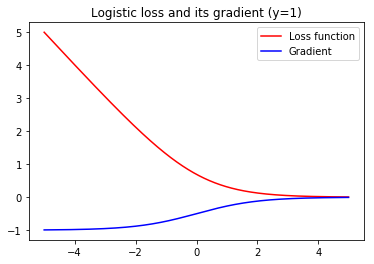

In [2]:
# for question 1 & 2
def logistic_loss(f, y):
    l = nd.log(1.0+nd.exp(-f*y))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(f, y)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [5]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32), label))

In [6]:
# for question 3
#X, y = train[0:9]
# pick out pullover/shirt, and sneaker/scandal
# a new preprocess function, can produce biased dataset
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_shirt = X[index_shirt[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    label1 = nd.ones((1, round(total_per_label*2*ratio))).astype(np.float32)
    label2 = nd.zeros((1, round(total_per_label*2*(1-ratio)))).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [7]:
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs):
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_data, test_data, loss, num_epochs, batch_size, None, None, trainer)

In [8]:
# half the dataset 
# note: use half the dataset, test acc is almost the same as using the full dataset
# so I used just 50 per label for train (total 100 for training), which leads to
# observable difference in test acc (~.975 v.s. ~.999)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=50, ratio=0.5) # ratio=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)
# full dataset
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=12000, ratio=0.5) # ration=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)

epoch 1, loss 20663.0071, train acc 0.660, test acc 0.739
epoch 2, loss 3380.5725, train acc 0.870, test acc 0.982
epoch 3, loss 0.0000, train acc 1.000, test acc 0.982
epoch 4, loss 0.0000, train acc 1.000, test acc 0.982
epoch 5, loss 0.0000, train acc 1.000, test acc 0.982
epoch 1, loss 21.4302, train acc 0.996, test acc 0.999
epoch 2, loss 6.1477, train acc 0.999, test acc 0.996
epoch 3, loss 5.8021, train acc 0.999, test acc 0.998
epoch 4, loss 2.7318, train acc 0.999, test acc 0.999
epoch 5, loss 2.9395, train acc 0.999, test acc 0.998


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [9]:
total_per_label = 6000
num_epochs = 8
print("Bias ratio now is:", .05)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.05)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
for r in range(1, 9, 1):
    ratio = r / 10.0
    print("Bias ratio now is:", ratio, "(unbiased)" if ratio==.5 else "")
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=ratio)
    batch_size = 64
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
print("Bias ratio now is:", .95)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.95)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)

Bias ratio now is: 0.05
epoch 1, loss 854.5355, train acc 0.925, test acc 0.500
epoch 2, loss 796.3949, train acc 0.931, test acc 0.727
epoch 3, loss 730.2132, train acc 0.935, test acc 0.718
epoch 4, loss 666.8963, train acc 0.937, test acc 0.751
epoch 5, loss 726.9587, train acc 0.938, test acc 0.747
epoch 6, loss 701.6993, train acc 0.938, test acc 0.501
epoch 7, loss 687.4906, train acc 0.938, test acc 0.722
epoch 8, loss 666.2604, train acc 0.938, test acc 0.663
Bias ratio now is: 0.1 
epoch 1, loss 1753.0879, train acc 0.874, test acc 0.614
epoch 2, loss 1477.1151, train acc 0.883, test acc 0.644
epoch 3, loss 1243.9493, train acc 0.889, test acc 0.774
epoch 4, loss 1254.2510, train acc 0.888, test acc 0.665
epoch 5, loss 1306.4104, train acc 0.894, test acc 0.758
epoch 6, loss 1310.9209, train acc 0.885, test acc 0.751
epoch 7, loss 1494.7907, train acc 0.888, test acc 0.685
epoch 8, loss 1333.2427, train acc 0.892, test acc 0.723
Bias ratio now is: 0.2 
epoch 1, loss 2728.7483,

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
    - We can set the weights as $.5/\lambda$ for the class with fraction $\lambda$, and $.5/(1-\lambda)$ for the class with fraction $1-\lambda$.
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


### For question 1, weighted loss for training

In [10]:
'''
# a new preprocess procedure, 0/1 for two labels
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data
'''

'\n# a new preprocess procedure, 0/1 for two labels\ndef preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above\n    X, y = mnist_train[:]\n    # pick up the indices\n    index_sweater = np.where(y==3)[0]\n    index_shirt = np.where(y==6)[0]\n    index_scandal = np.where(y==5)[0]\n    index_sneaker = np.where(y==7)[0]\n    # create the class for training, biased\n    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]\n    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]\n    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]\n    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]\n    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)\n    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)\n    train_feature = nd.flatten(train_feature)\n    label1 = nd.ones((1, total_per_label)).astype(np.float32)\n    label2 = nd

In [11]:
# preperations
def logistic(z):
    return 1. / (1. + nd.exp(-z))
# loss function, with weight
def log_loss(output, y, ratio):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    # biased loss
    return  - nd.nansum((1-ratio)/(.5+ratio) * y * nd.log(yhat) + ratio/(.5+ratio) * (1-y) * nd.log(1-yhat))
    # original loss
    # return  - nd.nansum(y * nd.log(yhat) + (1-y) * nd.log(1-yhat))
# train_model
def train_model(epochs, train_data, net, trainer, batch_size, ratio, f=None):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                if f is not None:
                    ratio = f(data)
                    print('now the ratio is:', ratio)
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label, ratio)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e + 1, cumulative_loss ))
# test_model
def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        # visual = nd.concat(output.reshape(shape=(64,1)), label.reshape(shape=(64,1)), dim=1)
        # print(visual)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

In [12]:
# combine train and test
def train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio):
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_model(num_epochs, train_data, net, trainer, batch_size, ratio)
    test_model(test_data)

In [13]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
for i in range(1, 10, 1):
    net = nn.Dense(1)
    net.collect_params().initialize(mx.init.Normal(sigma=.1))
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    batch_size = 64
    total_per_label = 6000
    ratio = i / 10
    num_epochs = 8
    print('Bias ratio now', ratio, '(unbiased)' if i==5 else '')
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio)

Bias ratio now 0.1 
Epoch 1, loss: 2293.854236602783
Epoch 2, loss: 1900.6216688156128
Epoch 3, loss: 1795.6514348983765
Epoch 4, loss: 1745.3912410736084
Epoch 5, loss: 1711.2154231071472
Epoch 6, loss: 1682.9071416854858
Epoch 7, loss: 1661.7057099342346
Epoch 8, loss: 1642.6873455047607
Accuracy: 0.909 (3638.0/4000)
Bias ratio now 0.2 
Epoch 1, loss: 2910.5924339294434
Epoch 2, loss: 2455.7730736732483
Epoch 3, loss: 2361.9671058654785
Epoch 4, loss: 2312.014328956604
Epoch 5, loss: 2278.777663230896
Epoch 6, loss: 2251.508640766144
Epoch 7, loss: 2230.4402556419373
Epoch 8, loss: 2212.1363010406494
Accuracy: 0.938 (3753.0/4000)
Bias ratio now 0.3 
Epoch 1, loss: 3014.93195104599
Epoch 2, loss: 2555.4225721359253
Epoch 3, loss: 2441.9201622009277
Epoch 4, loss: 2379.9370489120483
Epoch 5, loss: 2334.1819038391113
Epoch 6, loss: 2302.330412387848
Epoch 7, loss: 2275.1077551841736
Epoch 8, loss: 2251.829671859741
Accuracy: 0.964 (3857.0/4000)
Bias ratio now 0.4 
Epoch 1, loss: 2585.34

### For question 3.2

In [16]:
'''
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label = nd.ones((1, total_per_label*2)).astype(np.float32)
    train_labels = label.reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label = nd.zeros((1, 4000)).astype(np.float32)
    test_labels = label.reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data
'''
def generator(ratio, batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    bias_train, bias_test = preprocess(mnist_train, mnist_test, 6000, ratio)
    #train's label should be 1 and test's label should be 0
    f_train, l_train = bias_train[:]
    f_test, l_test = bias_test[:]
    
    l_train = nd.ones((1, 12000)).astype(np.float32)
    l_test = nd.zeros((1,4000)).astype(np.float32)
    
    trainLabel = nd.concat(l_train[:,:8000],l_test[:,:3000],dim = 1).reshape(shape=(-1,))
    testLabel = nd.concat(l_train[:,8000:],l_test[:,3000:],dim = 1).reshape(shape=(-1,))
    trainFeature = nd.concat(f_train[:8000], f_test[:3000], dim = 0)
    testFeature = nd.concat(f_train[8000:], f_test[3000:], dim = 0)

    train_data = gdata.dataset.ArrayDataset(trainFeature, trainLabel) 
    test_data = gdata.dataset.ArrayDataset(testFeature, testLabel) 
    return train_data, test_data

In [19]:
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
batch_size = 64
num_epochs = 80
ratio = 0.1
train_data, test_data = generator(ratio, batch_size)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_model(num_epochs, train_data, net, trainer, batch_size, 3./11)
test_model(test_data)
# this is the weight function we want, save to use later

Epoch 1, loss: 3479.024405479431
Epoch 2, loss: 3311.055130958557
Epoch 3, loss: 3254.8814668655396
Epoch 4, loss: 3220.461398124695
Epoch 5, loss: 3193.0148344039917
Epoch 6, loss: 3168.657790184021
Epoch 7, loss: 3146.972975730896
Epoch 8, loss: 3128.043023109436
Epoch 9, loss: 3110.5054140090942
Epoch 10, loss: 3094.8108167648315
Epoch 11, loss: 3079.7231674194336
Epoch 12, loss: 3066.011580467224
Epoch 13, loss: 3053.769106864929
Epoch 14, loss: 3042.0256843566895
Epoch 15, loss: 3030.9144897460938
Epoch 16, loss: 3019.8831825256348
Epoch 17, loss: 3010.5105028152466
Epoch 18, loss: 3002.5466957092285
Epoch 19, loss: 2992.681363105774
Epoch 20, loss: 2984.2905321121216
Epoch 21, loss: 2976.4787015914917
Epoch 22, loss: 2969.5953483581543
Epoch 23, loss: 2962.6136541366577
Epoch 24, loss: 2954.54501247406
Epoch 25, loss: 2949.128396987915
Epoch 26, loss: 2942.8842487335205
Epoch 27, loss: 2936.8440551757812
Epoch 28, loss: 2931.968253135681
Epoch 29, loss: 2926.643922805786
Epoch 30

In [20]:
# this is the weight function we want, save to use later
f_func = net
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
batch_size = 64
num_epochs = 10
ratio = 0.1
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
train_data, test_data = preprocess(mnist_train, mnist_test, 6000, ratio)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

def log_loss(output, y):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    # biased loss
    return  - nd.nansum(y * nd.log(yhat) + (1-y) * nd.log(1-yhat))

def train_model(epochs, train_data, net, trainer, batch_size, ratio, f=None):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                if f is not None:
                    weight = (f(data)).reshape(shape=label.shape)
                    #print('now the ratio is:', weight)
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label)#*nd.exp(-weight)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e + 1, cumulative_loss ))
train_model(num_epochs, train_data, net, trainer, batch_size, ratio, f=f_func)
test_model(test_data)

Epoch 1, loss: 3127.8128418922424
Epoch 2, loss: 2713.27677154541
Epoch 3, loss: 2566.1456394195557
Epoch 4, loss: 2526.2885801792145
Epoch 5, loss: 2481.1191387176514
Epoch 6, loss: 2477.72687125206
Epoch 7, loss: 2428.357762813568
Epoch 8, loss: 2430.0961005687714
Epoch 9, loss: 2424.0556530952454
Epoch 10, loss: 2391.093996524811
Accuracy: 0.734 (2937.0/4000)
